### 데이터 로드

클래스 목록: ['수지', '아이유', '카리나']
Train 데이터 개수: 192
Validation 데이터 개수: 29
Test 데이터 개수: 55
배치 크기: torch.Size([10, 3, 224, 224]), 라벨 크기: torch.Size([10])


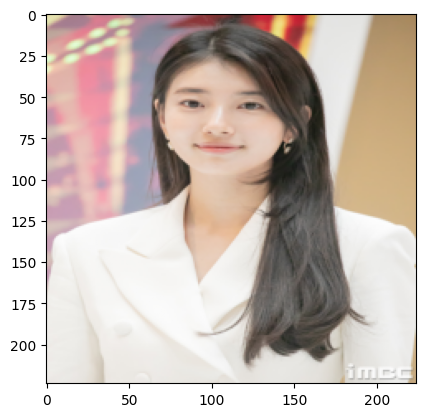

Label: 수지


In [61]:
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader
import torch
import numpy as np

SEED = 1030
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
np.random.seed(SEED)


data_transform = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ]
)

# ImageFolder를 사용하여 데이터 로드
train_dataset = ImageFolder(root="data/celebrity/train", transform=data_transform)
val_dataset = ImageFolder(root="data/celebrity/val", transform=data_transform)
test_dataset = ImageFolder(root="data/celebrity/test", transform=data_transform)

# DataLoader 설정
train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=10, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=10, shuffle=False)

print(f"클래스 목록: {train_dataset.classes}")
print(f"Train 데이터 개수: {len(train_dataset)}")
print(f"Validation 데이터 개수: {len(val_dataset)}")
print(f"Test 데이터 개수: {len(test_dataset)}")

data_iter = iter(train_loader)
images, labels = next(data_iter)
print(f"배치 크기: {images.shape}, 라벨 크기: {labels.shape}")

# 첫 번째 이미지 확인
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5  # 정규화 되돌리기
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

imshow(images[0])
print(f"Label: {test_dataset.classes[labels[0]]}")


### 모델 설정하기

In [62]:
import torch
import requests
import numpy as np
from PIL import Image
from torchvision import transforms, models
import matplotlib.pyplot as plt
import torch.nn as nn
from torchsummary import summary

model = models.resnet18(weights='IMAGENET1K_V1')
# model = models.resnet_18(pretrained=False)

device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)

summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,408
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]          36,864
       BatchNorm2d-6             [-1, 64, 8, 8]             128
              ReLU-7             [-1, 64, 8, 8]               0
            Conv2d-8             [-1, 64, 8, 8]          36,864
       BatchNorm2d-9             [-1, 64, 8, 8]             128
             ReLU-10             [-1, 64, 8, 8]               0
       BasicBlock-11             [-1, 64, 8, 8]               0
           Conv2d-12             [-1, 64, 8, 8]          36,864
      BatchNorm2d-13             [-1, 64, 8, 8]             128
             ReLU-14             [-1, 6

In [63]:
for p in model.parameters():  # freeze 기능
    p.requires_grad = False
model.fc

Linear(in_features=512, out_features=1000, bias=True)

In [64]:
# myclassifier = nn.Sequential(
#     # nn.Linear(model.fc.in_features, 512),
#     # nn.ReLU(),
#     # nn.Dropout(p=0.2),
#     # nn.Linear(512, 32),
#     # nn.ReLU(),
#     nn.Linear(512, 3)  # 클래스 개수 (훈련 시 사용한 개수와 일치해야 함)
# )
myclassifier = nn.Linear(512, 3)

model.fc = myclassifier
model = model.to(device)
model.fc

Linear(in_features=512, out_features=3, bias=True)

### 학습

In [65]:
from torch.utils.tensorboard import SummaryWriter
import time
import torch.optim as optim 

epochs = 1000
batch_size = 10
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=5e-5)

loss_history = {"train": [], "val": []}
acc_history = {"train": [], "val": []}

best_val_loss = 1.0
last_val_loss = float('inf')
patience = 5
patience_cnt = 0

log_dir = f"log/celebrity/{time.strftime('%Y%m%d-%H%M%S')}"
writer = SummaryWriter(log_dir)

for epoch in range(epochs):
    #### train ####
    model.train() 

    loss_train = 0.0
    corr_train = 0
    for data, target in train_loader:
        # GPU 보내기
        data = data.to(device)
        target = target.to(device)

        # 학습
        optimizer.zero_grad()
        yhat = model(data)
        loss = criterion(yhat, target)
        loss.backward()
        optimizer.step()

        # loss, correct 계산
        loss_train += loss.item() * batch_size
        corr_train += (yhat.argmax(dim=1) == target).sum().item()

    # loss, acc 저장
    train_loss = loss_train / len(train_dataset)
    train_accuracy = corr_train / len(train_dataset)
    
    loss_history["train"].append(train_loss)
    acc_history["train"].append(train_accuracy)

    #### validation ####
    model.eval()

    loss_val = 0.0
    corr_val = 0
    for data, target in val_loader:
        # GPU 보내기
        data = data.to(device)
        target = target.to(device)

        # 예측
        with torch.no_grad():
            pred = model(data)
            loss_val += criterion(pred, target).item() * batch_size
            corr_val += (pred.argmax(dim=1) == target).sum().item()

    # loss, acc 저장
    val_loss = loss_val / len(val_dataset)
    val_accuracy = corr_val / len(val_dataset)
    
    loss_history["val"].append(val_loss)
    acc_history["val"].append(val_accuracy)
    
    writer.add_scalars("Loss", {
        "Train": train_loss,
        "Validation": val_loss,
        },
        epoch
    )
    
    writer.add_scalars("Accuracy", {
        "Train": train_accuracy,
        "Validation": val_accuracy,
        },
        epoch
    )

    # Earlyl Stopping
    if val_loss < last_val_loss:
        patience_cnt = 0
        
    else:
        patience_cnt += 1
        print(f"개선 없음 - Early Stopping 카운터: {patience_cnt}/{patience}")
        if patience_cnt == patience:
            print("Early Stopping!")
            break
    last_val_loss = val_loss
    
    # Best 모델 저장
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        model_name = f"resnet_18_{epoch}"
        torch.save(model.state_dict(), f"{model_name}.pth")
        print(f"best model saved:", model_name)
        
    # 출력
    # if epoch % 1 == 0:
        # print(f"Epoch: {epoch}, Train Loss: {loss_train / len(train_data):.6f}, Train acc: {corr_train / len(train_data):.6f} Validation Loss: {loss_val / len(val_loader):.4f}, Validation acc: {corr_val / len(val_data):.4f}")
    print(
        f"Epoch: {epoch}\t"
        f"Train Loss: {train_loss:.4f}, Train Acc: {100 * train_accuracy:.2f}% | "
        f"Val Loss: {val_loss:.4f}, Val Acc: {100 * val_accuracy:.2f}%"
    )


writer.close()

Epoch: 0	Train Loss: 1.2451, Train Acc: 29.17% | Val Loss: 1.1834, Val Acc: 41.38%
개선 없음 - Early Stopping 카운터: 1/5
Epoch: 1	Train Loss: 1.1906, Train Acc: 30.73% | Val Loss: 1.1861, Val Acc: 41.38%
Epoch: 2	Train Loss: 1.1698, Train Acc: 33.85% | Val Loss: 1.1718, Val Acc: 31.03%
개선 없음 - Early Stopping 카운터: 1/5
Epoch: 3	Train Loss: 1.1640, Train Acc: 33.85% | Val Loss: 1.1868, Val Acc: 27.59%
Epoch: 4	Train Loss: 1.1487, Train Acc: 39.58% | Val Loss: 1.1862, Val Acc: 31.03%
개선 없음 - Early Stopping 카운터: 1/5
Epoch: 5	Train Loss: 1.1390, Train Acc: 39.06% | Val Loss: 1.1918, Val Acc: 27.59%
개선 없음 - Early Stopping 카운터: 2/5
Epoch: 6	Train Loss: 1.1317, Train Acc: 36.46% | Val Loss: 1.1919, Val Acc: 31.03%
Epoch: 7	Train Loss: 1.1062, Train Acc: 44.79% | Val Loss: 1.1694, Val Acc: 31.03%
Epoch: 8	Train Loss: 1.1052, Train Acc: 42.19% | Val Loss: 1.1662, Val Acc: 34.48%
개선 없음 - Early Stopping 카운터: 1/5
Epoch: 9	Train Loss: 1.1214, Train Acc: 41.15% | Val Loss: 1.1692, Val Acc: 34.48%
Epoch: 10	

<Figure size 600x400 with 0 Axes>

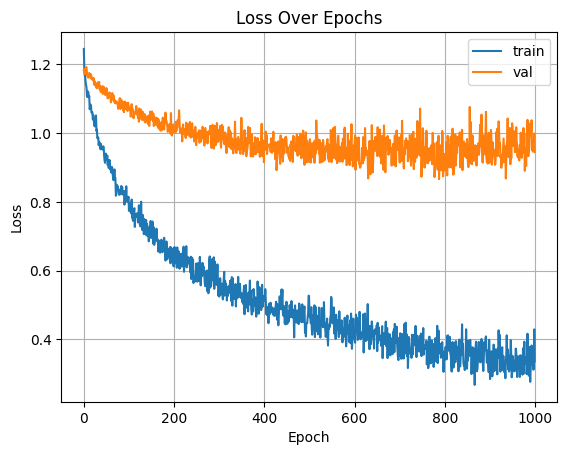

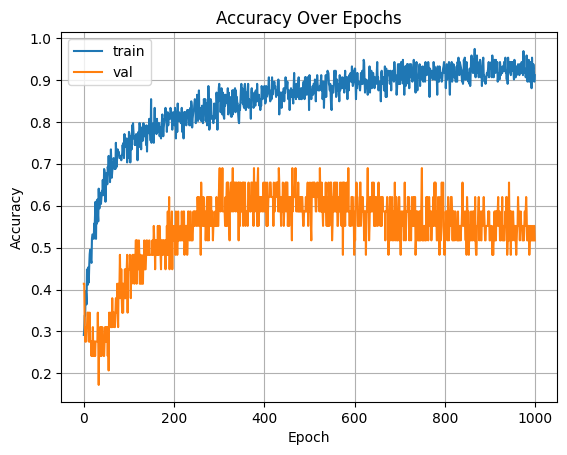

In [66]:
import matplotlib.pyplot as plt
import pandas as pd

# 학습 곡선 시각화
plt.figure(figsize=(6, 4))

# Train Loss와 Validation Loss 각각 그리기
loss_data = pd.DataFrame(loss_history)

loss_data.plot()
# loss_data[["train_loss", "val_loss"]].plot()

# 그래프 제목 및 라벨 설정

plt.title("Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid()  # 그리드 추가
plt.show()

acc_data = pd.DataFrame(acc_history)
acc_data.plot()
# loss_data[["train_acc", "val_acc"]].plot()

# 그래프 제목 및 라벨 설정
plt.title("Accuracy Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid()  # 그리드 추가
plt.show()

In [67]:
# 예측 -- 이 모델의 성능을 평가하기 위한 코드

best_model_name = "resnet_18_acc60.pth"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet18(weights='IMAGENET1K_V1')
model.fc = myclassifier
model.load_state_dict(torch.load(best_model_name))  # 가중치 로드
model.to(device)
model.eval()

corr_test = 0
for data, target in test_loader:
    # GPU 보내기
    data = data.to(device)
    target = target.to(device)

    # 예측
    with torch.no_grad():
        pred = model(data)
        corr_test += (pred.argmax(dim=1) == target).sum().item()

print(corr_test / len(test_dataset))

0.6


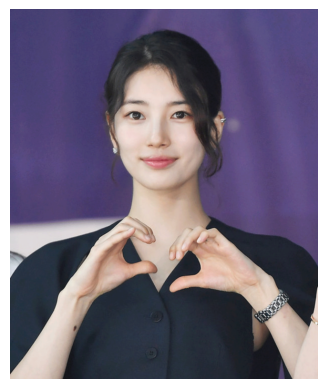

예측된 클래스: 수지
이미지의 예측 클래스: 수지


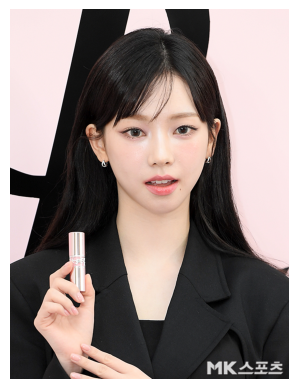

예측된 클래스: 아이유
이미지의 예측 클래스: 아이유


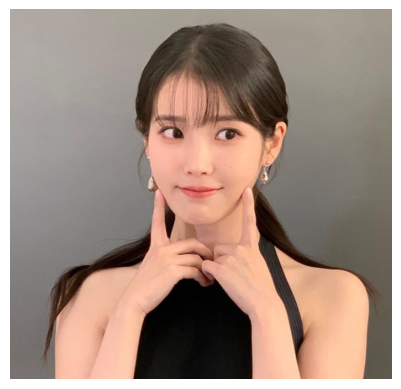

예측된 클래스: 아이유
이미지의 예측 클래스: 아이유


In [68]:
import torch
import requests
import numpy as np
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet18(weights='IMAGENET1K_V1')
model.fc = myclassifier
model.load_state_dict(torch.load(best_model_name))  # 가중치 로드
model.to(device)
model.eval()

# 클래스 이름 로드
class_names = train_dataset.classes  # 학습 데이터에서 클래스 정보 가져오기

def classify_image_from_url(image_url):
    response = requests.get(image_url, stream=True)
    image = Image.open(response.raw).convert("RGB")  # RGB 변환

    plt.imshow(image)
    plt.axis("off")
    plt.show()

    # 이미지 전처리
    image = data_transform(image).unsqueeze(0).to(device)  # 배치 차원 추가 후 GPU로 이동

    # 모델 예측
    with torch.no_grad():
        outputs = model(image)
        _, predicted = torch.max(outputs, 1)

    # 예측 결과 출력
    predicted_class = class_names[predicted.item()]
    print(f"예측된 클래스: {predicted_class}")

    return predicted_class

# 테스트 (URL을 입력해서 이미지 분류)
image_url = [
    "https://img.news-wa.com//img/upload/2024/11/12/NWC_20241112144306.gif.webp",
    "https://pimg.mk.co.kr/news/cms/202404/24/news-p.v1.20240424.bc3a15b9db35443599b06ef07cc26f8a_P1.jpg",
    "https://autocarnews.co.kr/wp-content/uploads/2024/09/2-2-optimized.png"
]
for iu in image_url:
    predicted_class = classify_image_from_url(iu)
    print(f"이미지의 예측 클래스: {predicted_class}")
